# WeightWatcher ResNet


### Analysis of pyTorch ResNet Models

ResNet, with the same number of layers,  is a much smaller model than VGG, with 20X less parameters.

We will see the power law exponents $\alpha$ approach 2 (or less) and do not vary much between layers until the very end, where the power law model breaks down and we have bulk+spikes.  Compare this to VGG, where $\alpha$ immediately increases with layer depth

Moreover, the average exponent $\langle\alpha\langle$ decreaes with test error, whereas for the VGG series, only the weighted alpha $\hat{\alpha}$  decreases with test error.


## Comparison of VGG and ResNet

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

### Key Idea:  Residual Connections

Improves gradient / information flow through the network

Because of this, there are much deeper ResNet variants.  In fact, some researchers have trained ResNet variants with 1001 layers!

## Results

In contrast to the VGG series, the ResNet Average Alpha $\langle\alpha\rangle$ is positively correlated with the Test Error:  smaller average alpha corresponds to better generalization.  Moreover, the layer $\alpha$ are fairly constant, and near $2.0$, for at least $3/4$ of the network

In [1]:
REPEAT = False # set true to rerun weightwatcher calculations from scratch
SAVE_DATA = False # DO NOT set True unless you want to replace all files in ./data

## Calculations of Results

In [2]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import numpy as np
import pandas as pd

from tqdm import tqdm 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext watermark
%watermark

Last updated: 2021-01-05T22:59:31.091190-08:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



### Import WeightWatcher

set custom Logging at WARN Level

In [4]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.7'

###  Helper Notebook to make Plots


In [5]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

In [6]:

series_name = 'ResNet'
all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']

colors = ['blue', 'green', 'teal', 'orange', 'red']


In [7]:


all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))




### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [8]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [9]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

## Run WeightWatcher 

### collect summary and details (as dataframes) for all models

In [10]:
all_details = []
all_summaries = []
if REPEAT:
    for im, name in enumerate(tqdm(all_names)):
        watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
        results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True,
                                 normalize=False, glorot_fix=False)

        summary =  watcher.get_summary()

        details  = watcher.get_details(results=results)
        details.drop(columns=['slice', 'slice_count'], inplace=True)
        details.dropna(inplace=True)
        details['NxM'] = pd.to_numeric(details.N * details.M)

        details.rename(columns=MP.WW4X_COMPAT_COLUMNS, inplace=True)
        all_details.append(details)

        for k,v in MP.WW4X_COMPAT_COLUMNS.items():
            summary[v]=summary[k]
        all_summaries.append(summary)
else:
    all_details, all_summaries = MP.read_ww2x_data(all_names)
    
if SAVE_DATA:
    MP.save_ww2x_data(all_names,all_details,all_summaries)

loading details in data/resnet18.csv
loading details in data/resnet34.csv
loading details in data/resnet50.csv
loading details in data/resnet101.csv
loading details in data/resnet152.csv
loading summary in  data/resnet18.txt
loading summary in  data/resnet34.txt
loading summary in  data/resnet50.txt
loading summary in  data/resnet101.txt
loading summary in  data/resnet152.txt


In [11]:
plt.rcParams.update({'font.size': 20})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [13]:
first_n_last_ids = [0, len(all_details)-1]

saving img/ResNet_log_norm_accs.png


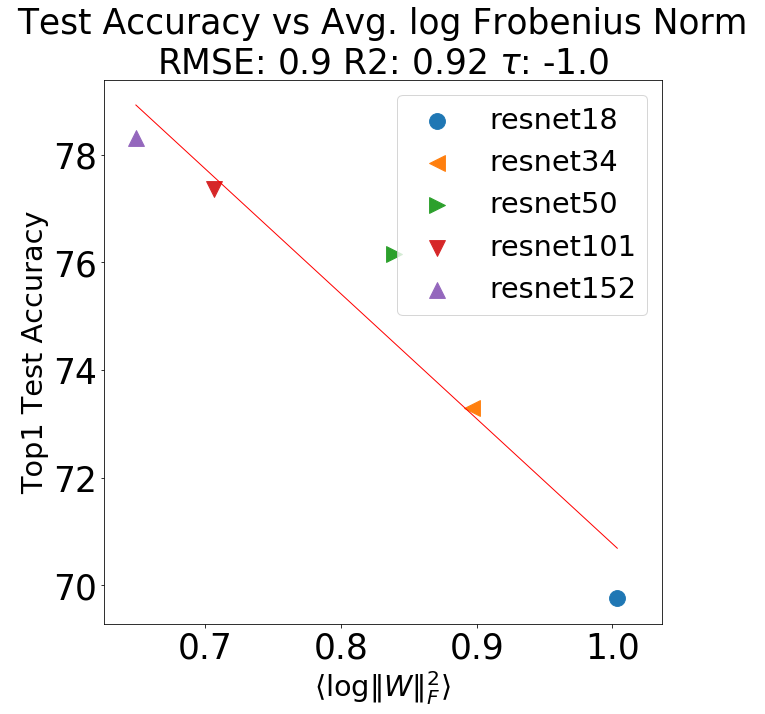

saving img/ResNet_alpha_accs.png


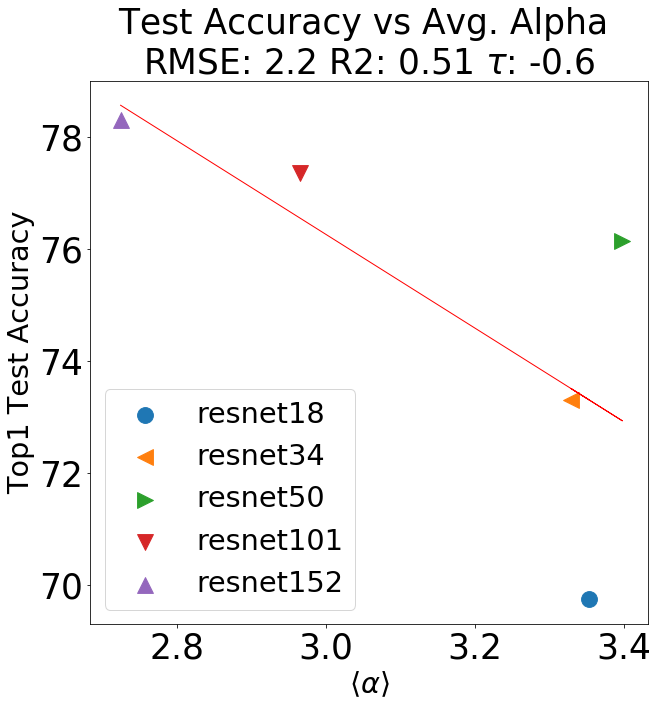

saving img/ResNet_alpha_weighted_accs.png


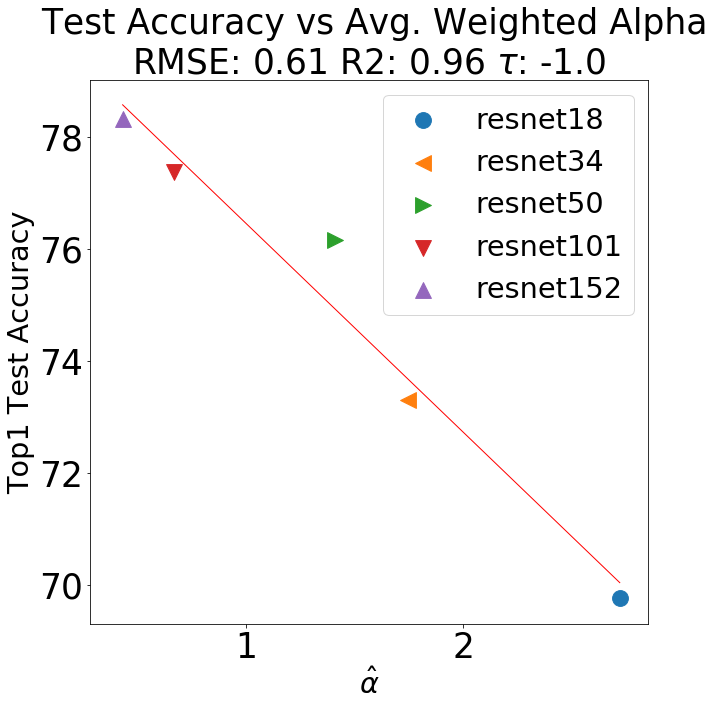

saving img/ResNet_log_spectral_norm_accs.png


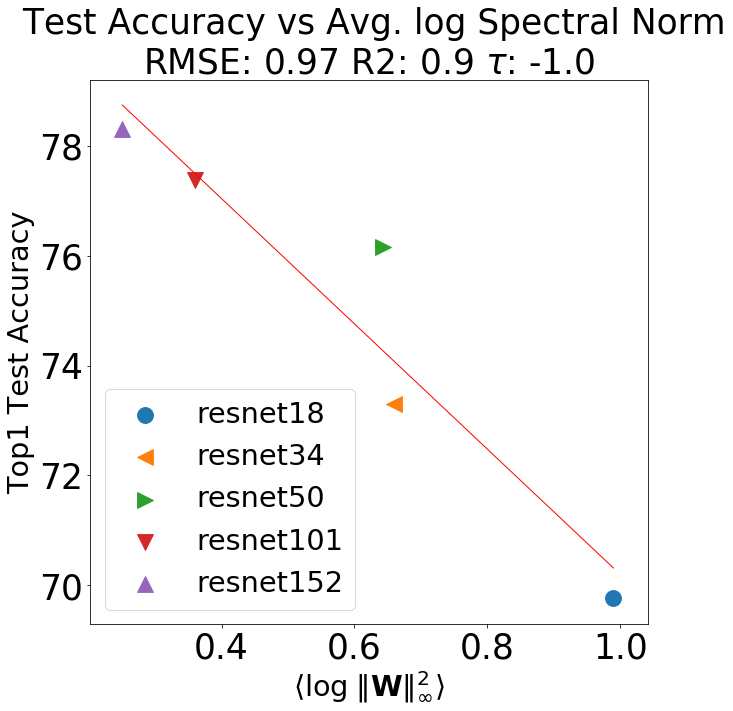

saving img/ResNet_log_stable_rank_accs.png


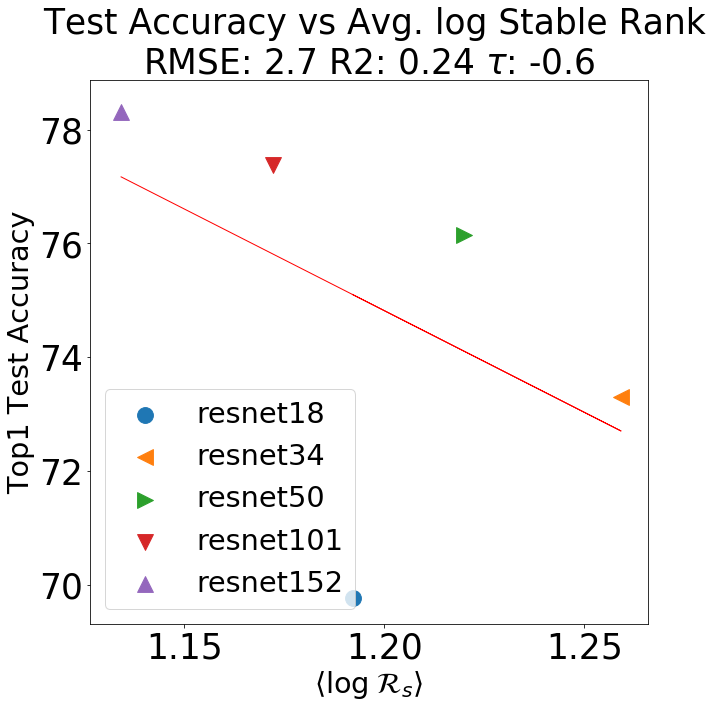

saving img/ResNet_mp_softrank_accs.png


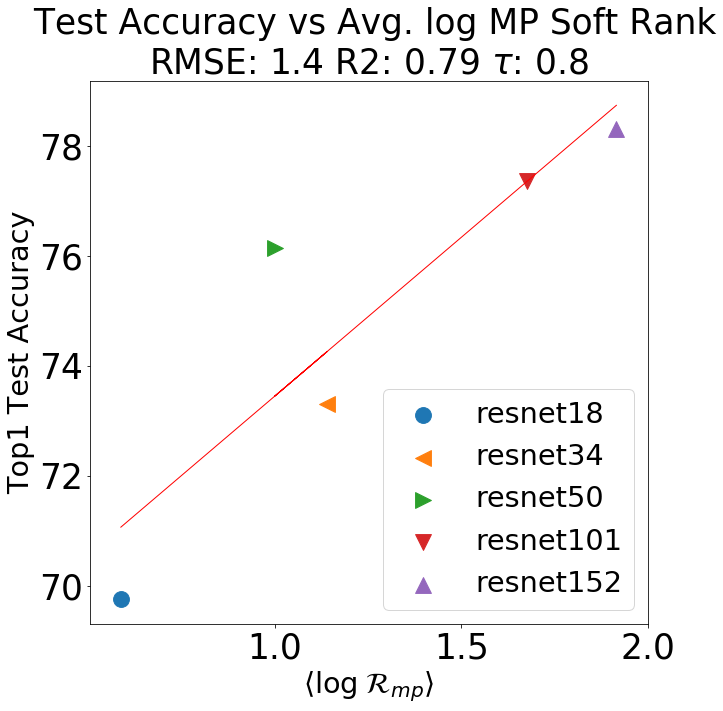

saving img/ResNet_log_alpha_norm_accs.png


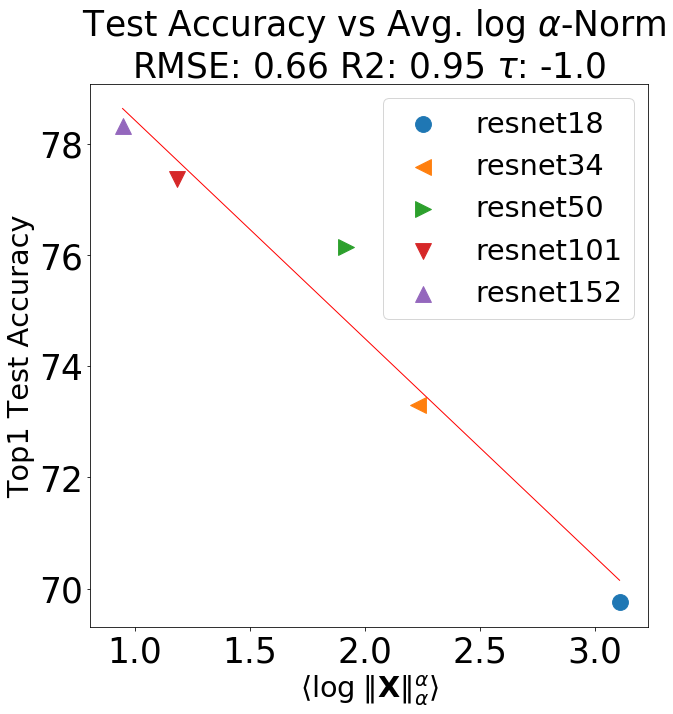

In [14]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

saving img/ResNet_all_log_norm_hist.png


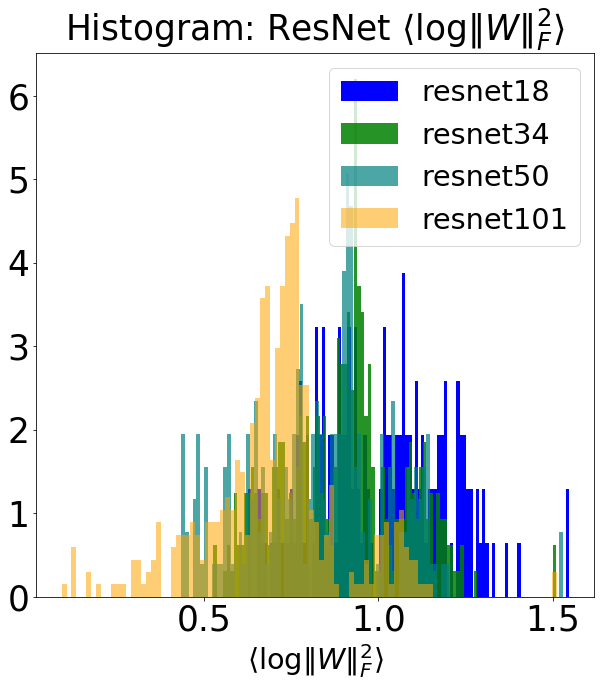

saving img/ResNet_fnl_log_norm_hist.png


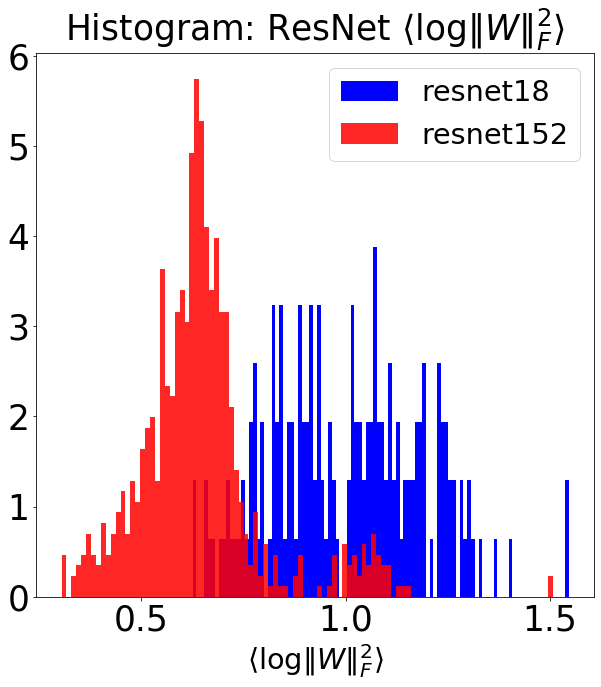

saving img/ResNet_all_alpha_hist.png


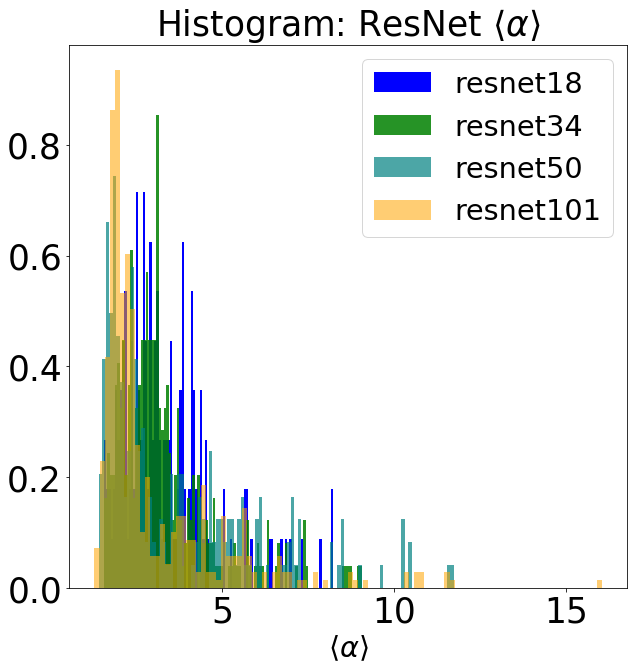

saving img/ResNet_fnl_alpha_hist.png


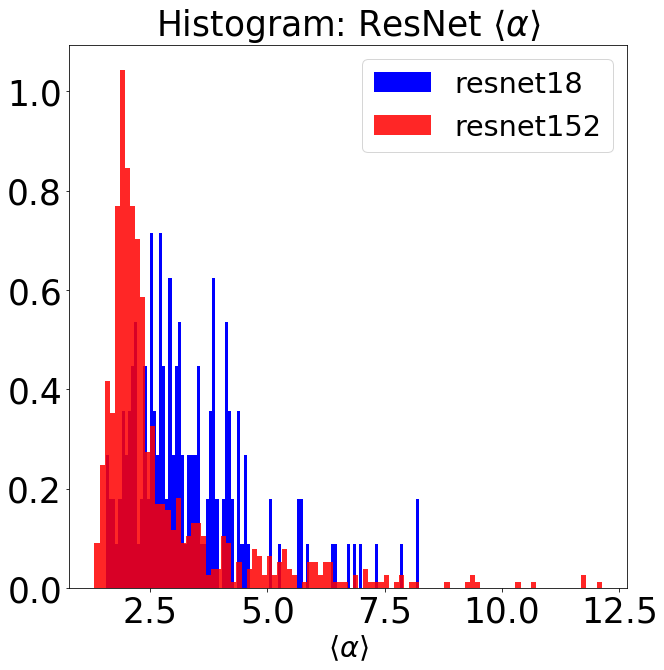

saving img/ResNet_all_alpha_weighted_hist.png


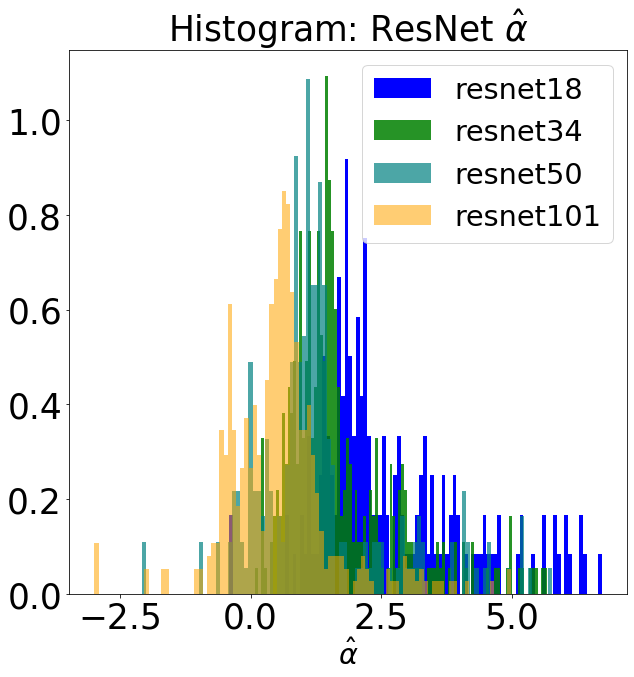

saving img/ResNet_fnl_alpha_weighted_hist.png


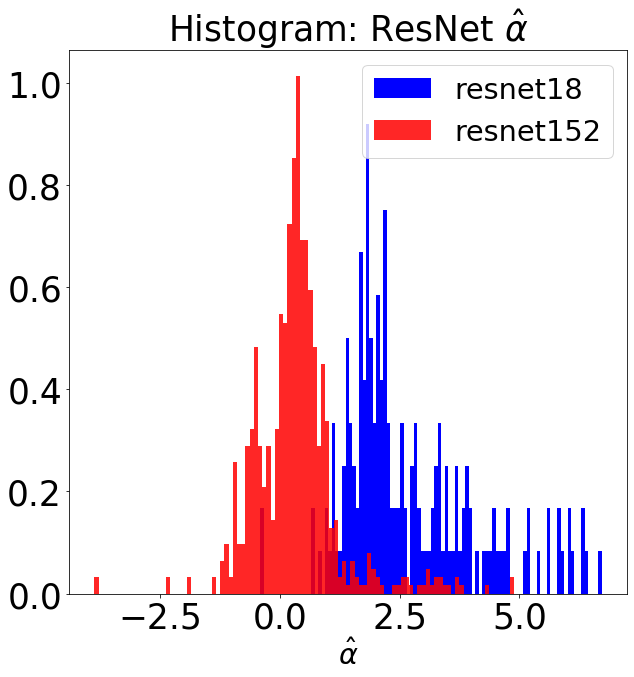

saving img/ResNet_all_log_stable_rank_hist.png


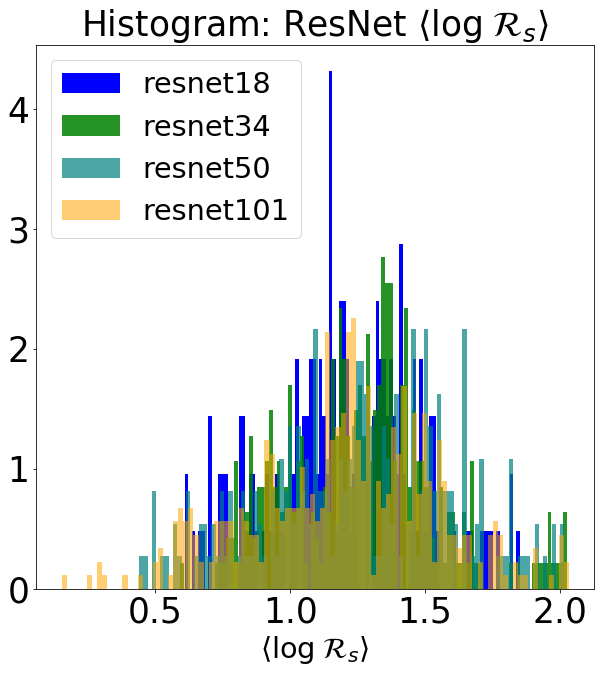

saving img/ResNet_fnl_log_stable_rank_hist.png


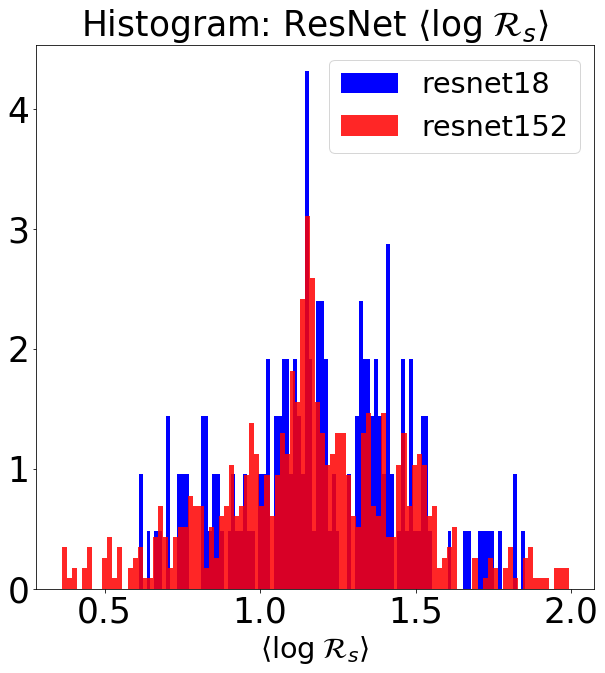

saving img/ResNet_all_log_spectral_norm_hist.png


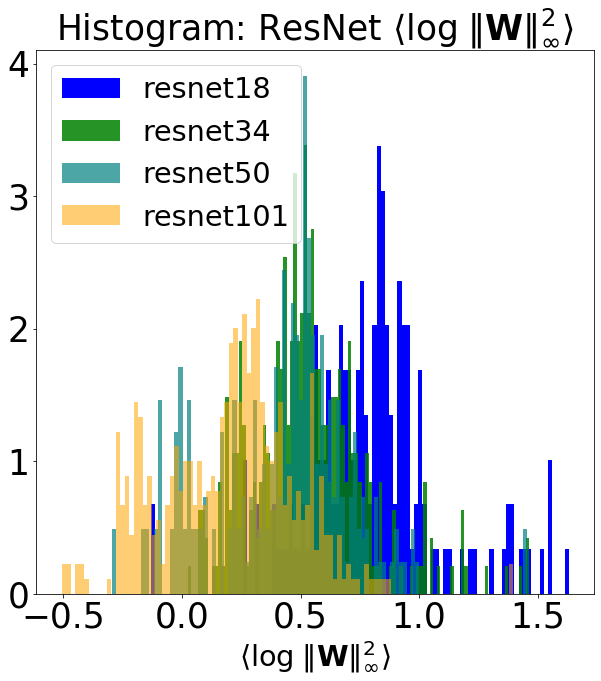

saving img/ResNet_fnl_log_spectral_norm_hist.png


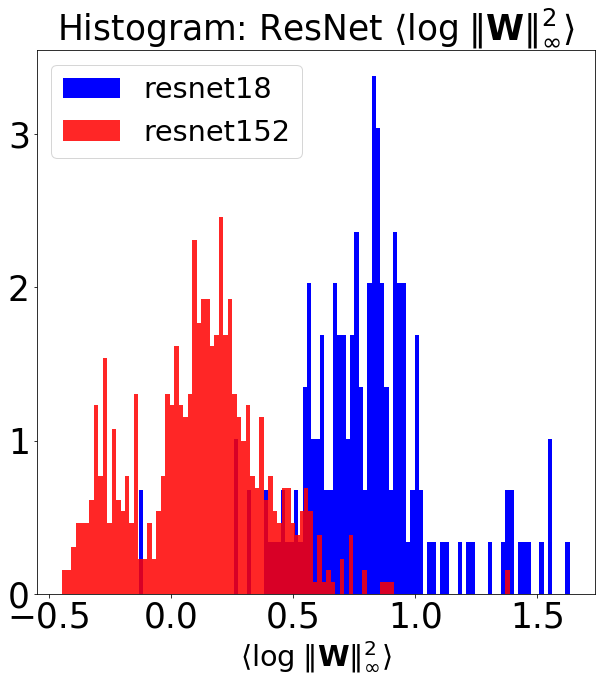

saving img/ResNet_all_mp_softrank_hist.png


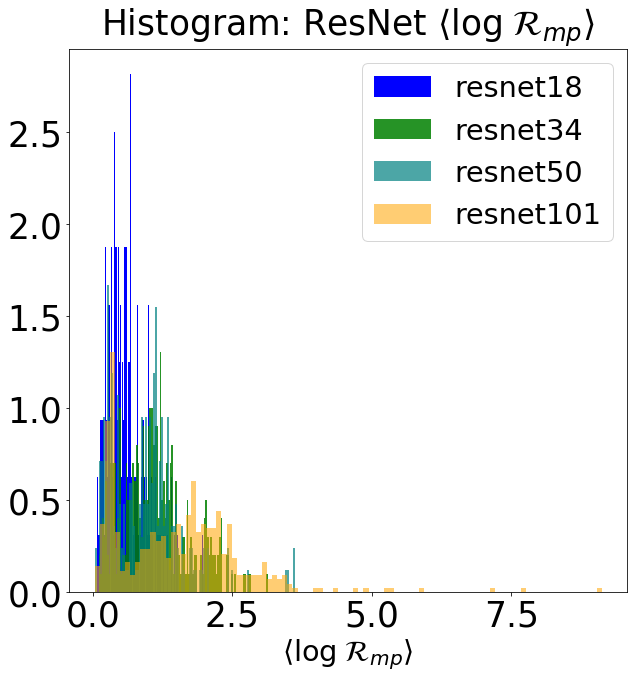

saving img/ResNet_fnl_mp_softrank_hist.png


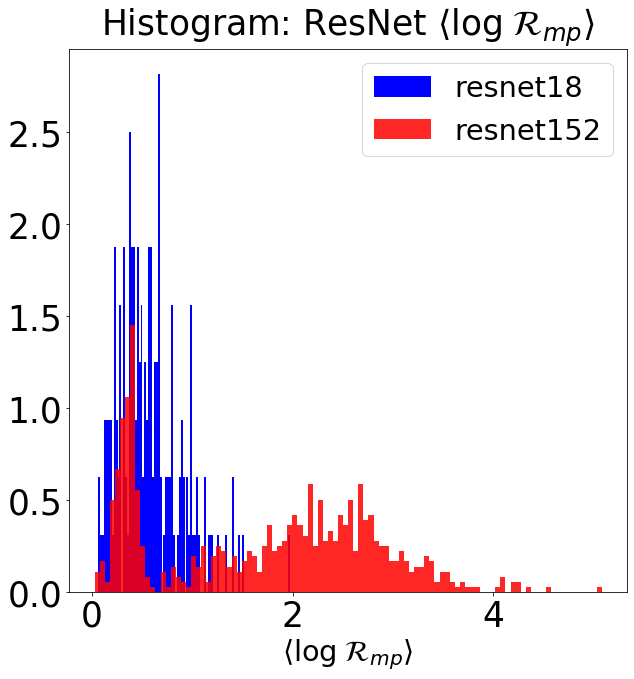

saving img/ResNet_all_log_alpha_norm_hist.png


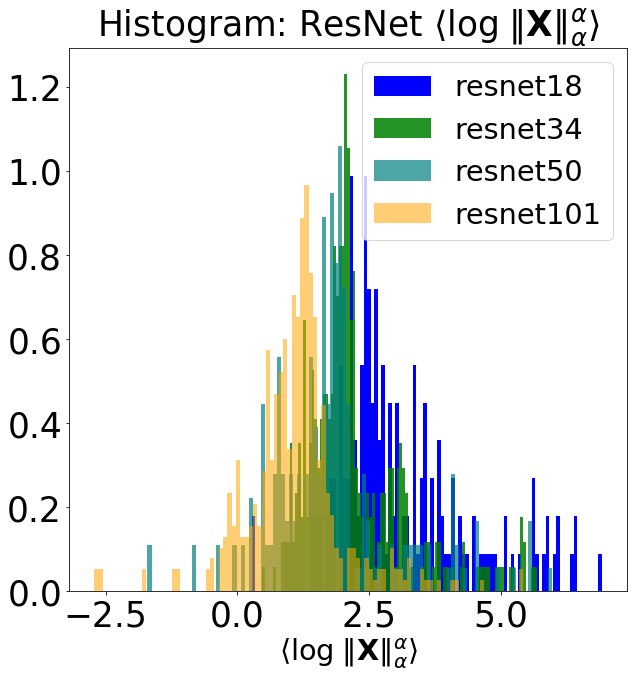

saving img/ResNet_fnl_log_alpha_norm_hist.png


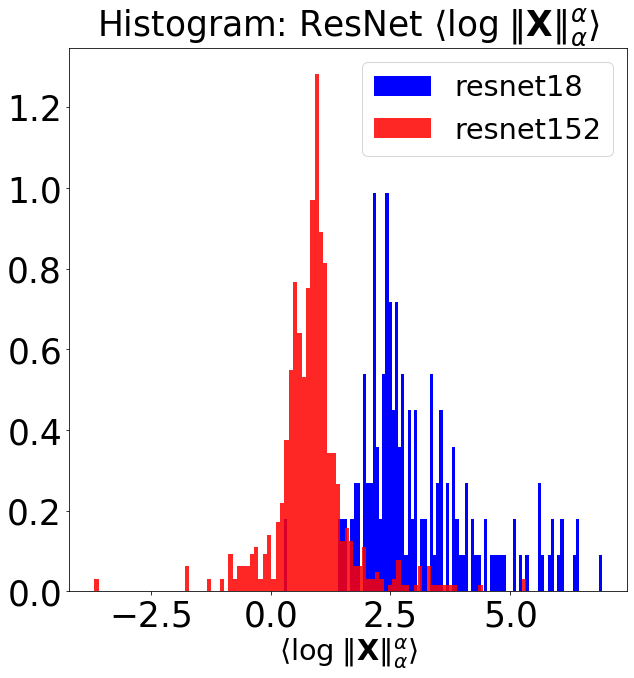

In [15]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

saving img/ResNet_all_log_norm_depth.png


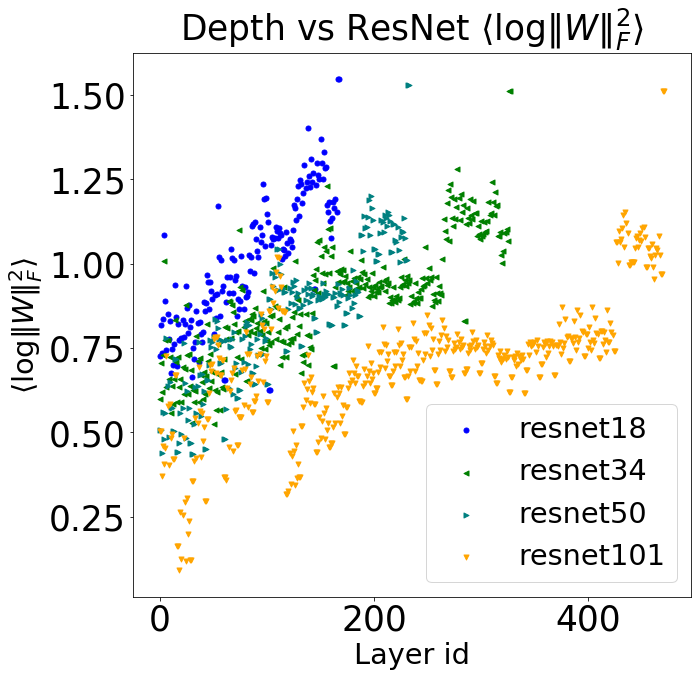

saving img/ResNet_fnl_log_norm_depth.png


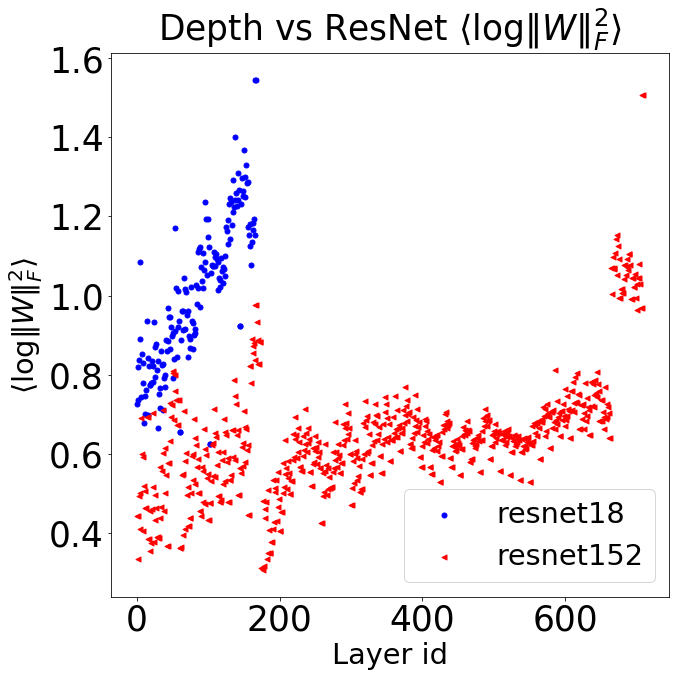

saving img/ResNet_all_alpha_depth.png


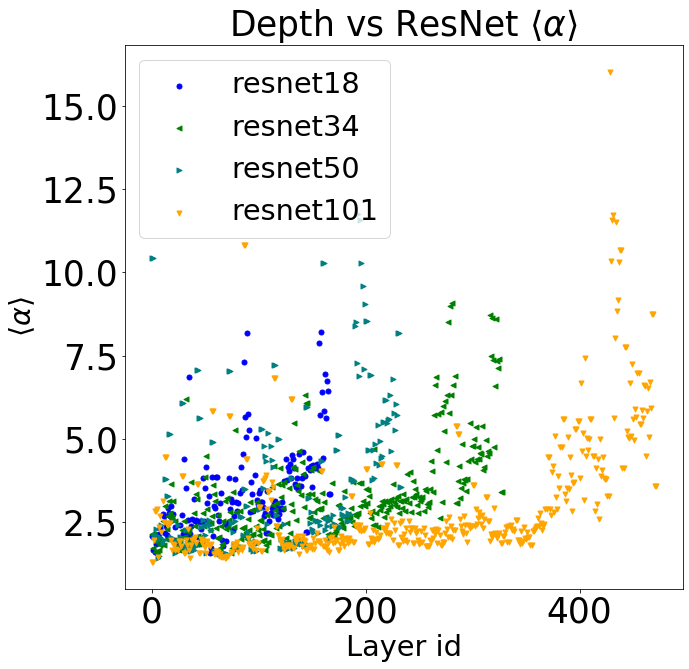

saving img/ResNet_fnl_alpha_depth.png


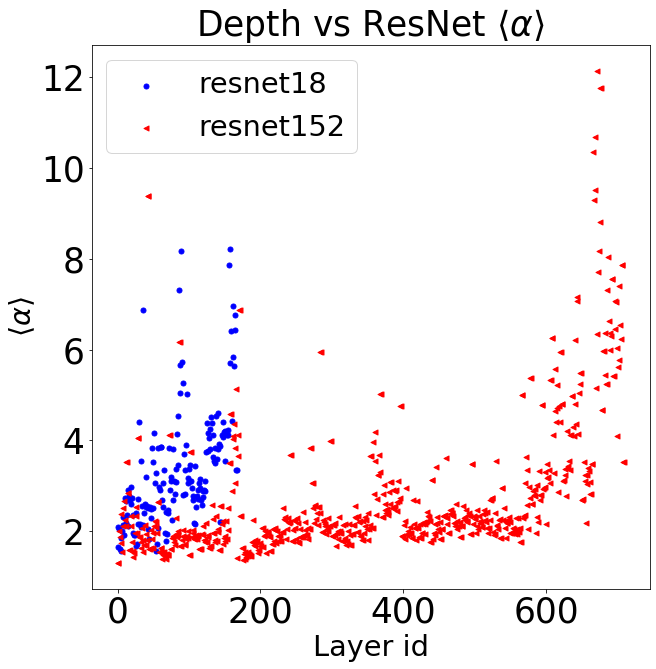

saving img/ResNet_all_alpha_weighted_depth.png


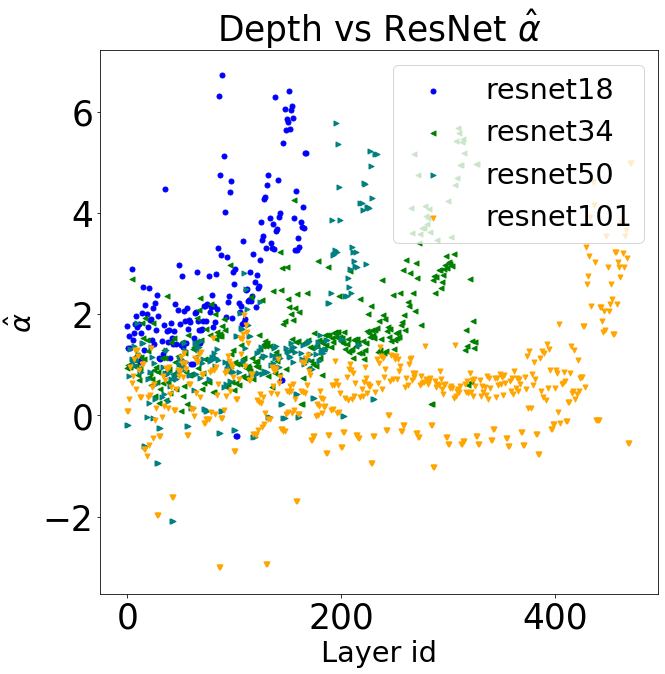

saving img/ResNet_fnl_alpha_weighted_depth.png


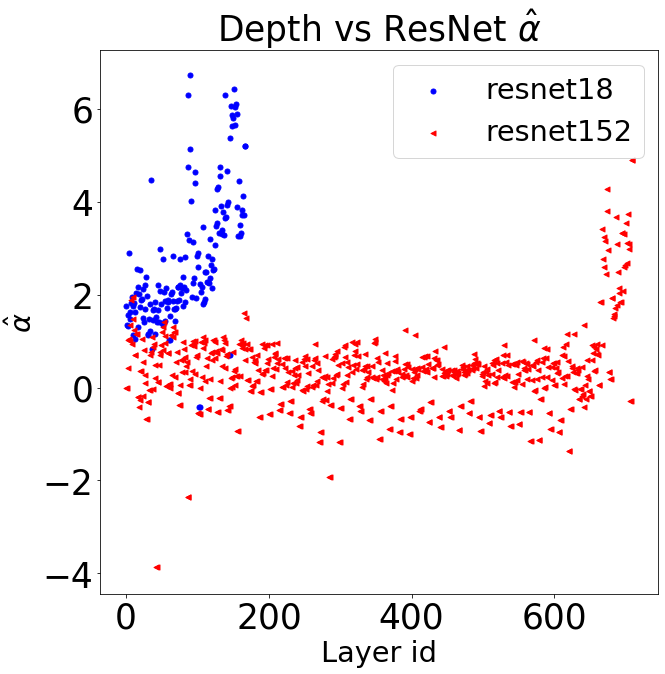

saving img/ResNet_all_log_stable_rank_depth.png


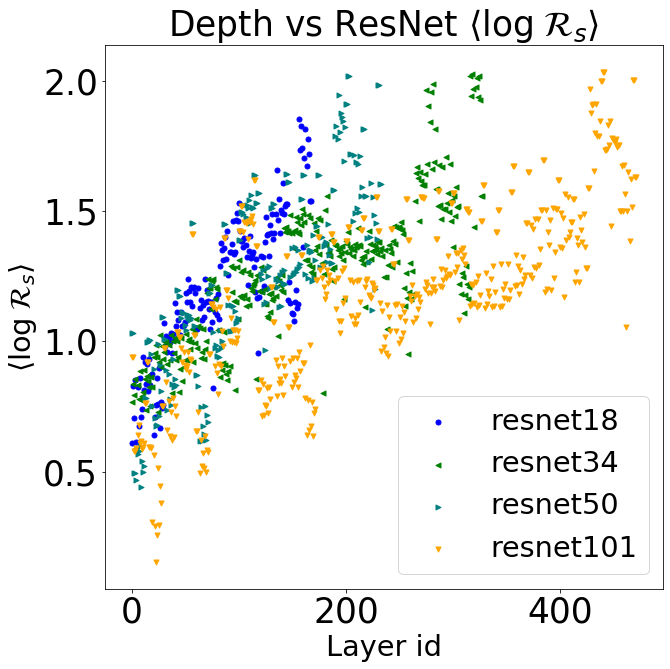

saving img/ResNet_fnl_log_stable_rank_depth.png


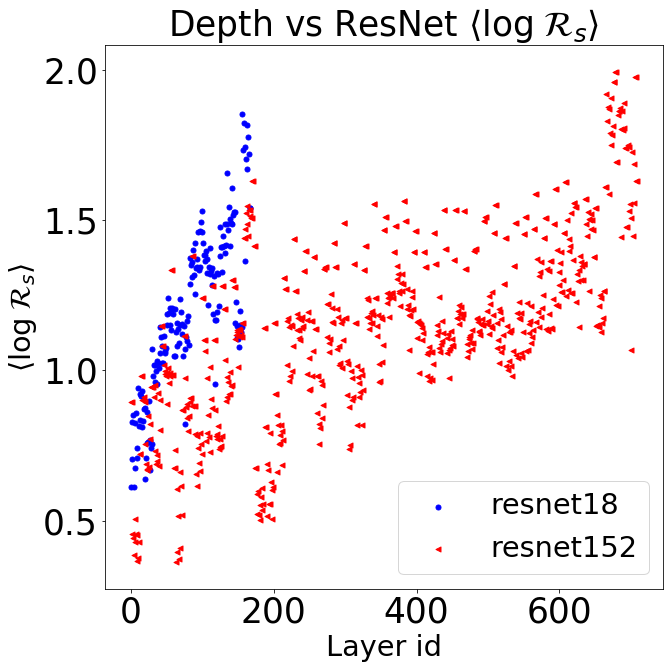

saving img/ResNet_all_log_spectral_norm_depth.png


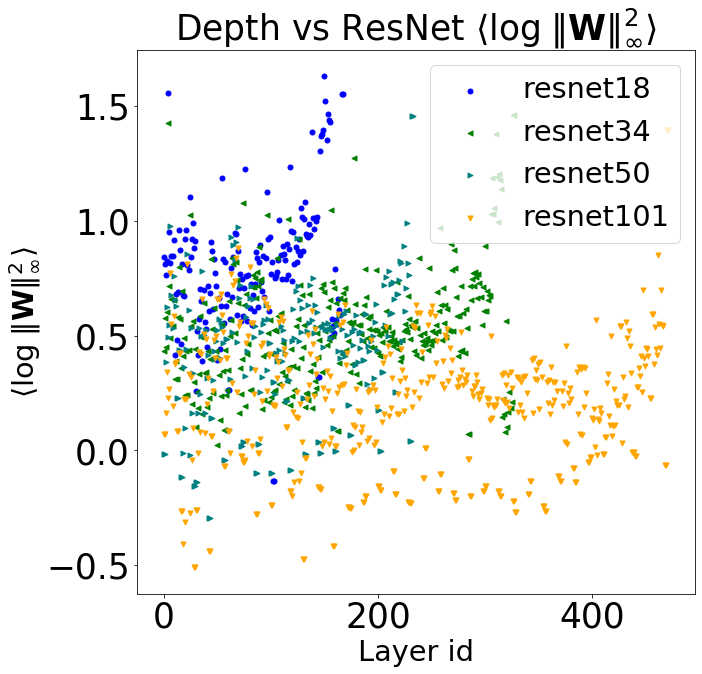

saving img/ResNet_fnl_log_spectral_norm_depth.png


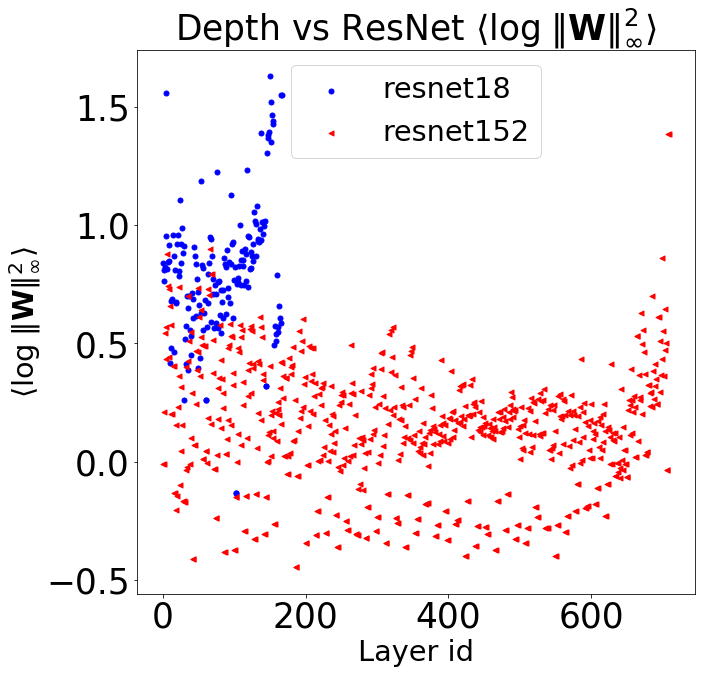

saving img/ResNet_all_mp_softrank_depth.png


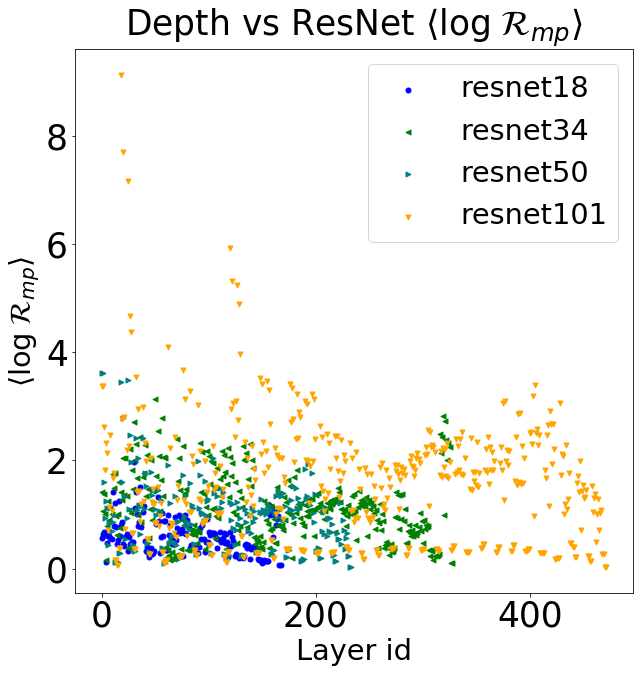

saving img/ResNet_fnl_mp_softrank_depth.png


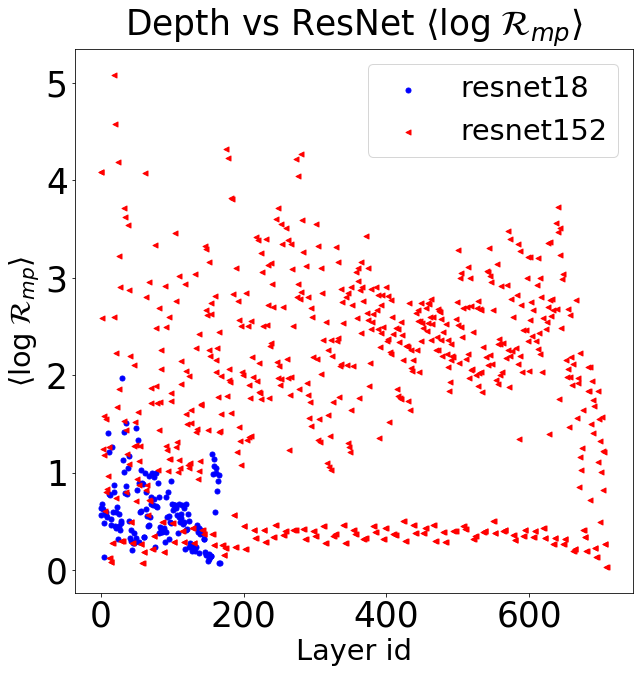

saving img/ResNet_all_log_alpha_norm_depth.png


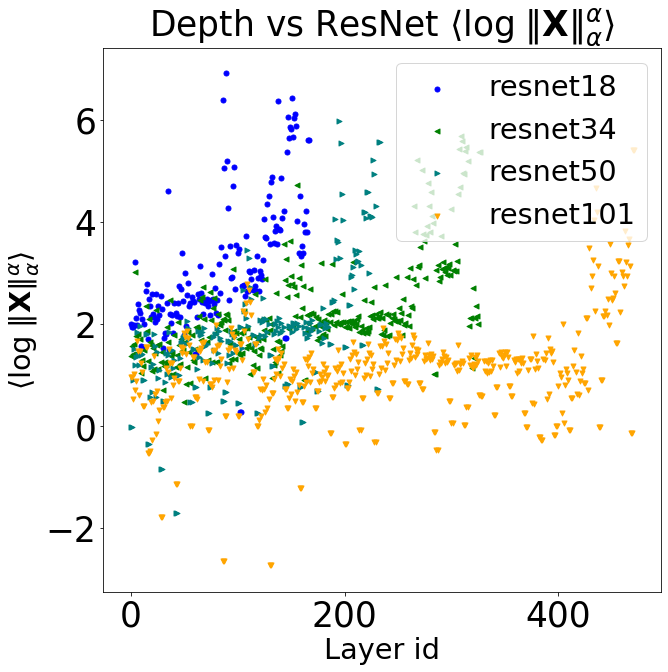

saving img/ResNet_fnl_log_alpha_norm_depth.png


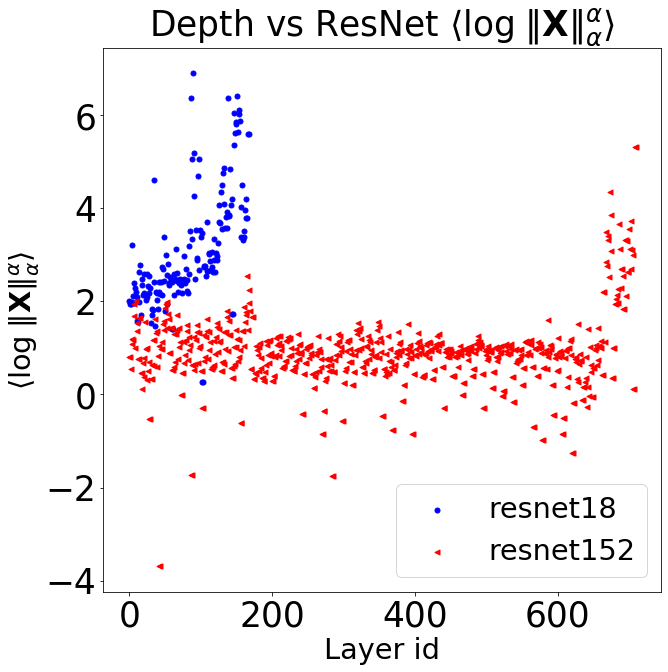

In [16]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details,  first_n_last_ids)

## Zoom in on ResNet

In [17]:
len(all_details)

5

saving img/resnet_alpha_overlap_depth.png


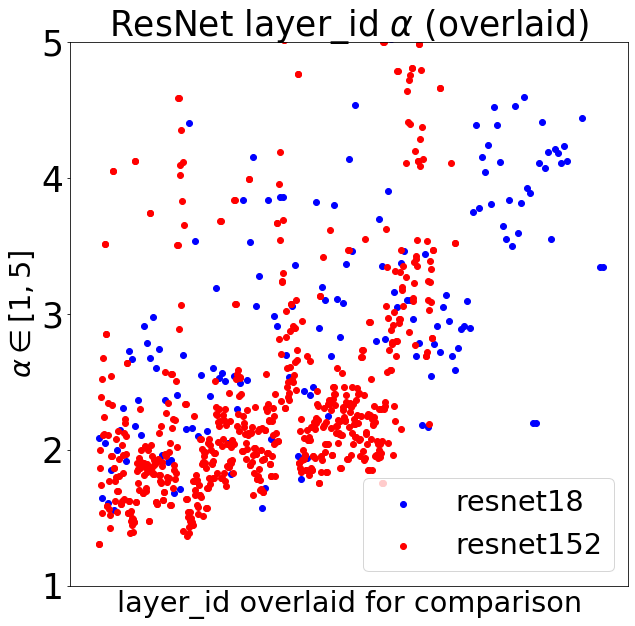

In [18]:
for im, details in enumerate(all_details):
        
    if im in [0,4]:      
        details = all_details[im]
        name = all_names[im]
        x = details.index.to_numpy()
        if im==0:
            x=x*6
        y = details['alpha'].to_numpy()

        plt.scatter(x,y, label=name, color=colors[im])
        

plt.tick_params(
axis='x',          # changes apply to the x-axis
which='both',      # both major and minor ticks are affected
bottom=False,      # ticks along the bottom edge are off
top=False,         # ticks along the top edge are off
labelbottom=False) # labels along the bottom edge are off

plt.ylim(1,5)
plt.xlabel("layer_id overlaid for comparison")
plt.ylabel(r"$\alpha\in[1,5]$")
plt.legend()
plt.title(r"ResNet layer_id $\alpha$ (overlaid)")

figname = "img/resnet_alpha_overlap_depth.png"
print("saving {}".format(figname))
plt.savefig(figname)
plt.show()
